In [1]:
import numpy as np
import ot
from ot.datasets import make_1D_gauss
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm, sem, t
import scipy.stats as stats
import time

## CI for measures

In [3]:
df = pd.DataFrame()

In [4]:
res =200
scale_param = 200
X = np.linspace(0,scale_param,res)
noises = np.logspace(start=-3,stop=1, num=22)

In [5]:
for noise in tqdm(noises):
    df = run_experiment_and_append(df, res=res, noise_param=noise, scale_param=scale_param)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:23<00:00,  1.08s/it]


In [12]:
df.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,200.0,0.001000,200.0,0.014182,0.000200,70.984151,59.968073,0.0,59.980720,0.224595,59.668233,59.680816,1.005025,1.000107,0.159291,0.160589,0.991992
1,200.0,0.001551,200.0,0.014182,0.000482,29.422600,59.968073,0.0,59.997756,0.392025,59.668233,59.697767,1.005025,1.000492,0.159291,0.162417,0.980965
2,200.0,0.002404,200.0,0.014182,0.001166,12.157821,59.968073,0.0,60.544657,0.569180,59.668233,60.241934,1.005025,0.992449,0.159291,0.166123,0.959347
3,200.0,0.003728,200.0,0.014182,0.002812,5.042673,59.968073,0.0,60.554033,0.778882,59.668233,60.251263,1.005025,0.994118,0.159291,0.175037,0.910643
4,200.0,0.005780,200.0,0.014182,0.006704,2.115494,59.968073,0.0,61.086226,1.342048,59.668233,60.780794,1.005025,0.992330,0.159291,0.196394,0.812069


In [8]:
# Calculating the approximation of what the linear distances should be using the chi-squared distribution
degrees_of_freedom = res
expected_chi2 = degrees_of_freedom
approx_distances = df['SNR'] * np.sqrt(2 * expected_chi2)
approx_distances_with_original = df['SNR'] * np.sqrt(2 * expected_chi2) + df['Distances_Linear']

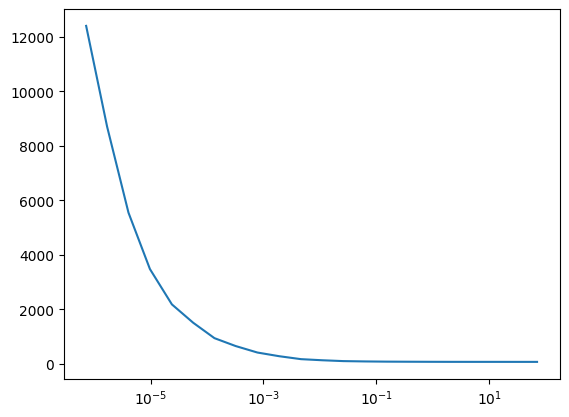

In [13]:
x = df['SNR']
y = df['Distances_Noised']

plt.plot(x, y)
plt.xscale('log')

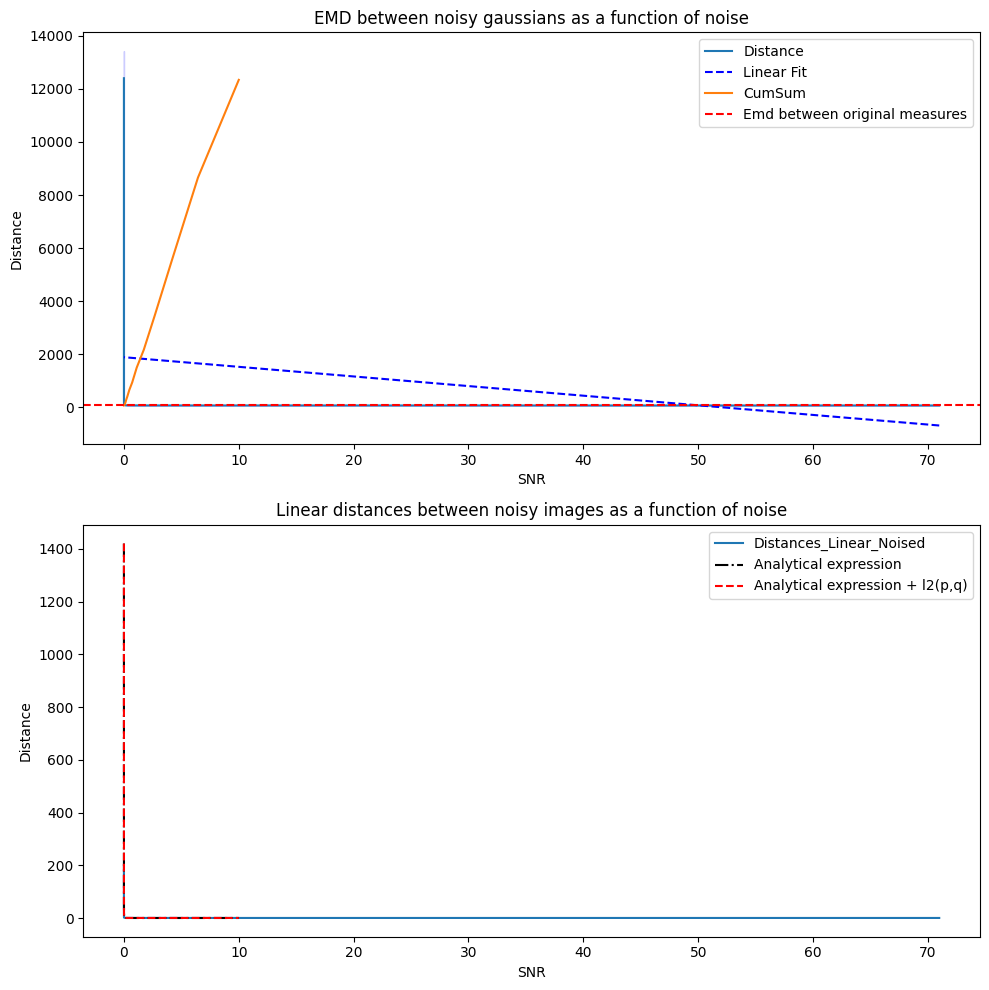

In [9]:
# Compute the linear fit parameters (slope and y-intercept)
slope, intercept = np.polyfit(x, y, 1)
y_fit = slope * x + intercept

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,1,1)
# Plot the distances
ax1.plot(x, y, label='Distance')
# Fill between for confidence intervals for Distances_Noised
ax1.fill_between(x, 
                 y - df['CI_Distances_Noised'], 
                 y + df['CI_Distances_Noised'], 
                 color='b', alpha=0.2) # light blue shading for confidence interval

# Plot the linear fit line
ax1.plot(x, y_fit, 'b--', label='Linear Fit')
# ax1.set_xscale('log') # Uncomment if you want to set x-axis to logarithmic scale
ax1.plot(df['Noise_Param'], df['Cumsum_Noised'], label='CumSum')
ax1.set_title('EMD between noisy gaussians as a function of noise')
ax1.set_xlabel('SNR')
ax1.set_ylabel('Distance')
ax1.axhline(y=df['Distances_Classic'][0], color='r', linestyle='--', label='Emd between original measures')
ax1.legend()


# For Distances_Linear_Noised
ax2 = fig.add_subplot(2,1,2)
y_linear_noised = df['Distances_Linear_Noised']
ax2.plot(x, y_linear_noised, label='Distances_Linear_Noised')
ax2.plot(df['Noise_Param'], approx_distances, 'k-.', label='Analytical expression')
ax2.plot(df['Noise_Param'], approx_distances_with_original, color = 'r', linestyle = '--', label='Analytical expression + l2(p,q)')
ax2.set_title('Linear distances between noisy images as a function of noise')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Distance')
ax2.legend()

plt.tight_layout()
plt.show()

### Looking into a smaller set of noises

In [142]:
noises = noises[:10]

In [143]:
df_subset = df[df['Noise_Param'] <= noises[-1]]

In [144]:
approx_distances_subset = df_subset['Noise_Param'] * np.sqrt(2 * expected_chi2)
approx_distances_with_original_subset = df_subset['Noise_Param'] * np.sqrt(2 * expected_chi2) + df_subset['Distances_Linear']

In [145]:
x = df_subset['Noise_Param']
y = df_subset['Distances_Noised']
y_linear_noised = df_subset['Distances_Linear_Noised']

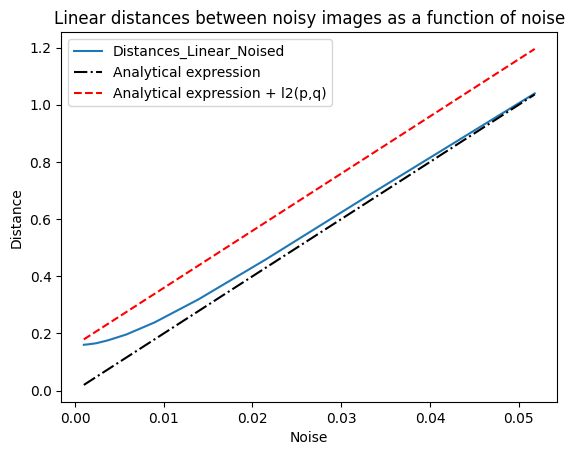

In [146]:
plt.plot(x, y_linear_noised, label='Distances_Linear_Noised')
plt.plot(df_subset['Noise_Param'], approx_distances_subset, 'k-.', label='Analytical expression')
plt.plot(df_subset['Noise_Param'], approx_distances_with_original_subset, color = 'r', linestyle = '--', label='Analytical expression + l2(p,q)')
plt.title('Linear distances between noisy images as a function of noise')
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.legend()

## Images

In [79]:
im1 = np.zeros([10,10])
im1[1:3,1:3] = 1
im2 = np.zeros([10,10])
im2[7:9,7:9] = 1

im1 = im1 / im1.sum()
im2 = im2 / im2.sum()

In [80]:
columns = ['Noise_Param', 'Distances_Classic', 'Distances_Noised', 'CI_Distances_Noised', 'Ratios_EMD', 
           'Distances_Linear', 'Distances_Linear_Noised', 'CI_Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

noises = np.logspace(start=-3,stop=1, num=22)

In [74]:
noises = noises[:10]

In [81]:
for noise in tqdm(noises):
    df = run_experiment_and_append_images(df, im1, im2, noise)

  0%|                                                                                                                                                                            | 0/22 [00:00<?, ?it/s]C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\utils\utils.py:548: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00, 10.96it/s]


In [82]:
df.head()

,Noise_Param,Distances_Classic,Distances_Noised,CI_Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,CI_Distances_Linear_Noised,Ratios_Linear
0,0.001000,12.0,12.022592,0.010432,0.998138,0.707107,0.707295,0.000293,0.999738
1,0.001551,12.0,12.036503,0.017150,0.997013,0.707107,0.707640,0.000486,0.999257
2,0.002404,12.0,12.039220,0.025379,0.996844,0.707107,0.708043,0.000683,0.998699
3,0.003728,12.0,12.095551,0.039416,0.992342,0.707107,0.709227,0.001040,0.997059
4,0.005780,12.0,12.194608,0.066255,0.984706,0.707107,0.714579,0.001695,0.989671


In [83]:
M, N = im1.shape
degrees_of_freedom = M * N
expected_chi2 = 2 * degrees_of_freedom
approx_distances = df['Noise_Param'] * np.sqrt(expected_chi2)

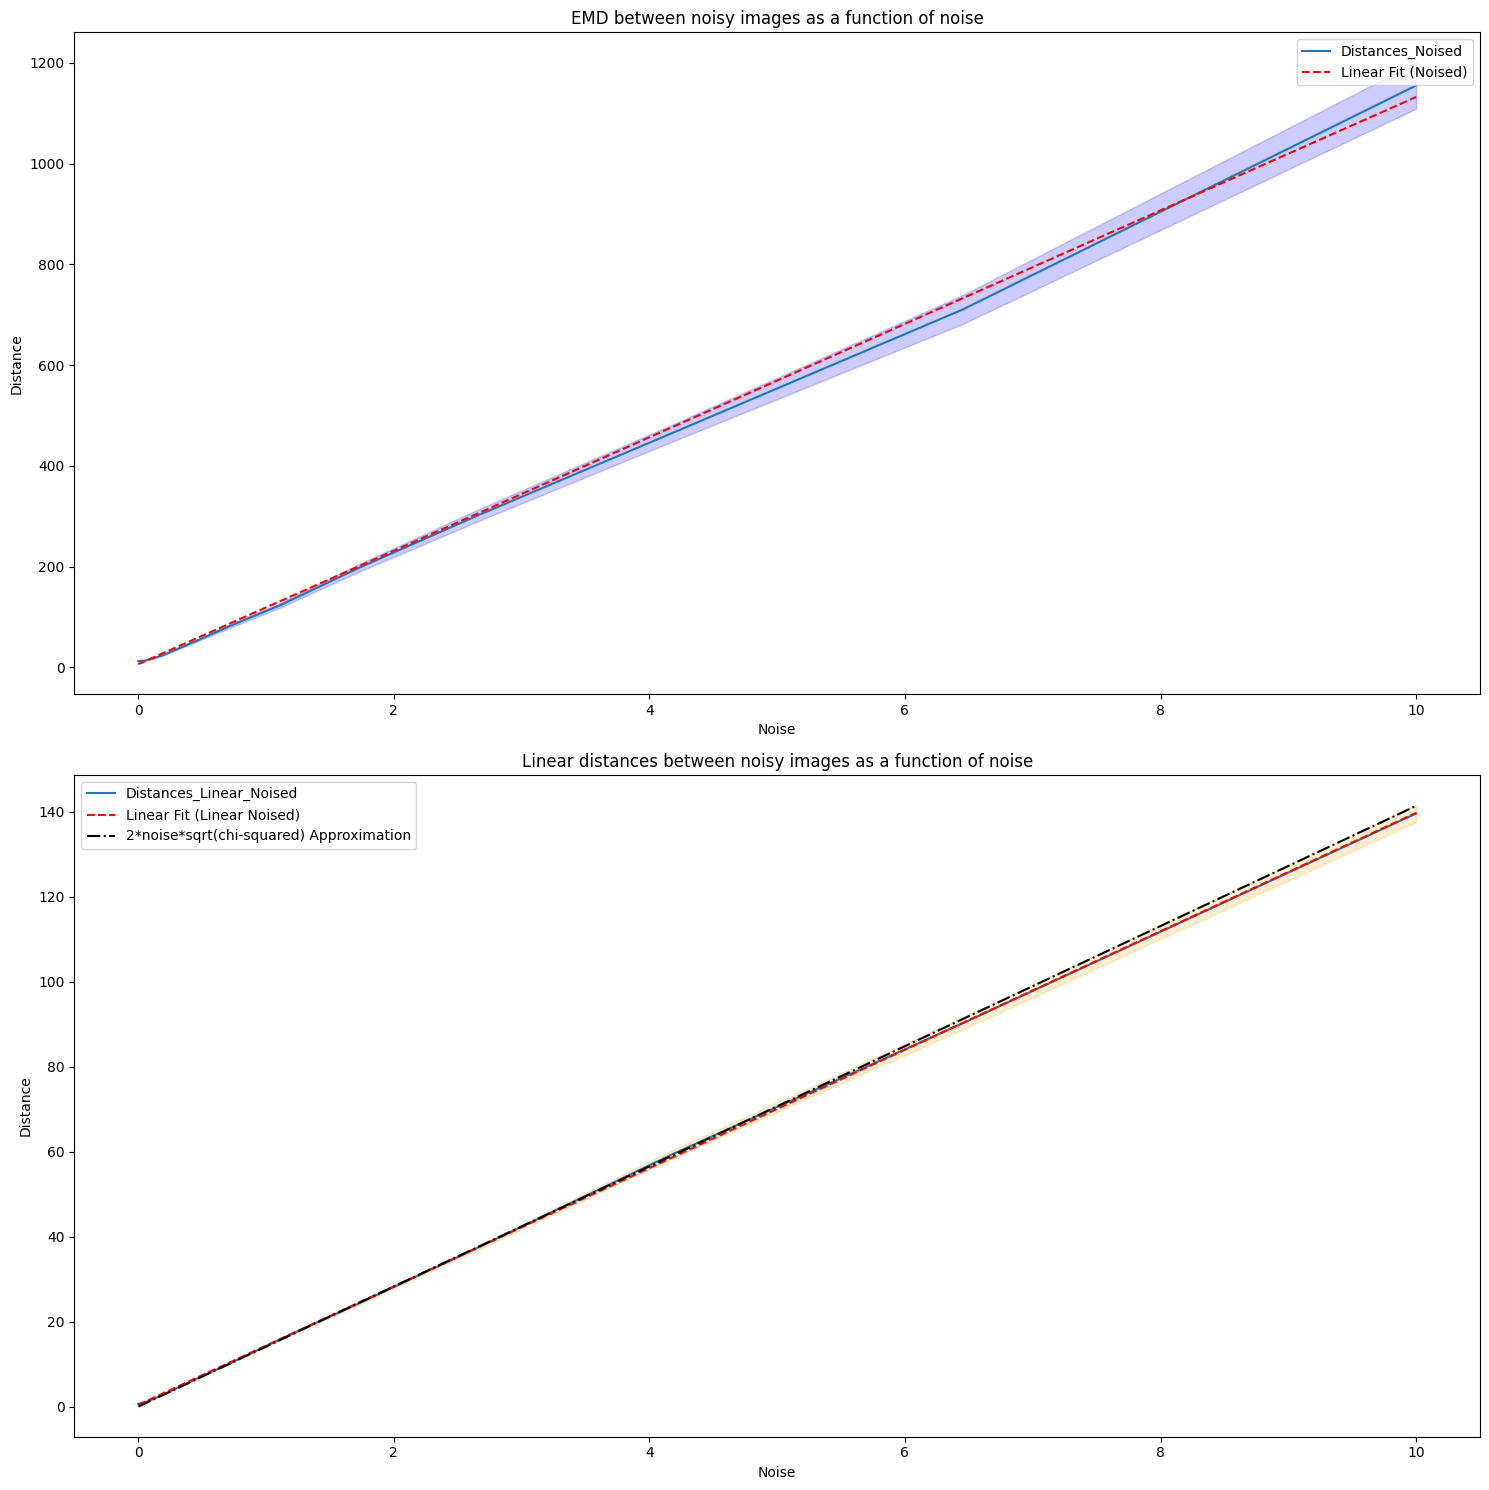

In [84]:
fig = plt.figure(figsize=(15,15))

# For Distances_Noised
ax1 = fig.add_subplot(2,1,1)
x = df['Noise_Param']
y_noised = df['Distances_Noised']
slope_noised, intercept_noised = np.polyfit(x, y_noised, 1)
y_fit_noised = slope_noised * x + intercept_noised

ax1.plot(x, y_noised, label='Distances_Noised')
ax1.fill_between(x, 
                 y_noised - df['CI_Distances_Noised'], 
                 y_noised + df['CI_Distances_Noised'], 
                 color='b', alpha=0.2)
ax1.plot(x, y_fit_noised, 'r--', label='Linear Fit (Noised)')
ax1.set_title('EMD between noisy images as a function of noise')
ax1.set_xlabel('Noise')
ax1.set_ylabel('Distance')
ax1.legend()

# For Distances_Linear_Noised
ax3 = fig.add_subplot(2,1,2)
y_linear_noised = df['Distances_Linear_Noised']
slope_linear_noised, intercept_linear_noised = np.polyfit(x, y_linear_noised, 1)
y_fit_linear_noised = slope_linear_noised * x + intercept_linear_noised

ax3.plot(x, y_linear_noised, label='Distances_Linear_Noised')
ax3.fill_between(x, 
                 y_linear_noised - df['CI_Distances_Linear_Noised'], 
                 y_linear_noised + df['CI_Distances_Linear_Noised'], 
                 color='orange', alpha=0.2)
ax3.plot(x, y_fit_linear_noised, 'r--', label='Linear Fit (Linear Noised)')
ax3.plot(df['Noise_Param'], approx_distances, 'k-.', label='2*noise*sqrt(chi-squared) Approximation')
ax3.set_title('Linear distances between noisy images as a function of noise')
ax3.set_xlabel('Noise')
ax3.set_ylabel('Distance')
ax3.legend()

plt.tight_layout()
plt.show()

## W(p,p')
Trying to understand the effect of noising a single measure and whats the difference between this single measure and its noised option, the noised measure will be normalized.

### One sample

In [147]:
res = 500
noise = 1e-3
scale_param = 100
noises = np.logspace(start=-3,stop=1, num=22)

In [148]:
print(noise)

0.001


In [149]:
p, q, p_post, q_post, C = create_distribs_and_costs(res=res, noise=noise, scale_parameter=scale_param)

noise_p = np.random.normal(0, noise, res)
p_noised = p + noise_p

p_noised_pos, p_noised_neg = split_signed_measure(p_noised)

p_added_neg = p + p_noised_neg

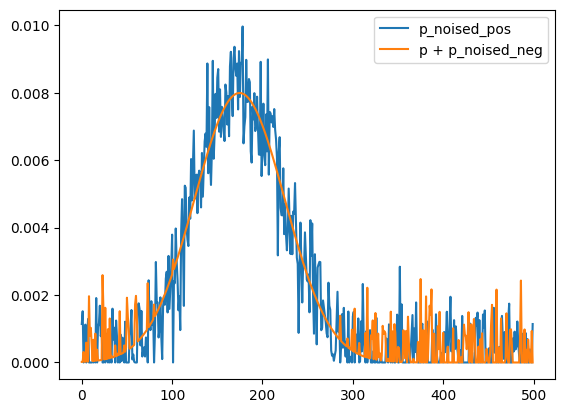

In [150]:
plt.plot(p_noised_pos, label='p_noised_pos')
plt.plot(p_added_neg, label='p + p_noised_neg')
#plt.plot(p_post, label='p_post')
#plt.plot(q_post, label='q_post')
plt.legend()

In [151]:
p_new = p_added_neg / p_added_neg.sum()
p_noised_new = p_noised_pos / p_noised_pos.sum()

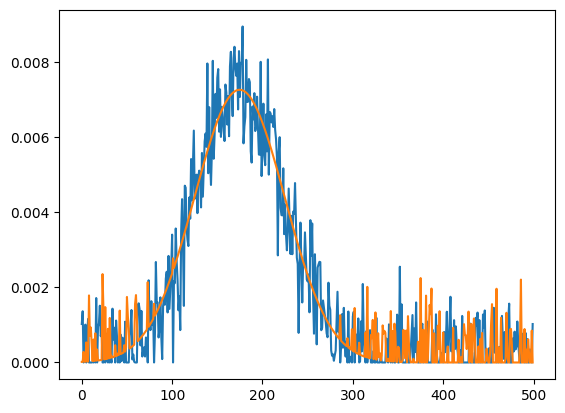

In [152]:
plt.plot(p_noised_new)
plt.plot(p_new)

### Looking at W(p,p')

In [182]:
df2 = pd.read_csv('results_measures_expanded.csv')

In [183]:
unique_noises = df2['Noise_Param'].unique()
unique_scale = df2['Scale_Param'].unique()
unique_res = df2['Res'].unique()

In [167]:
len(df2.index)

2200

Text(0.5, 1.0, 'Distance vs Resolution for scale=100.0 and noise=2.682695795279725')

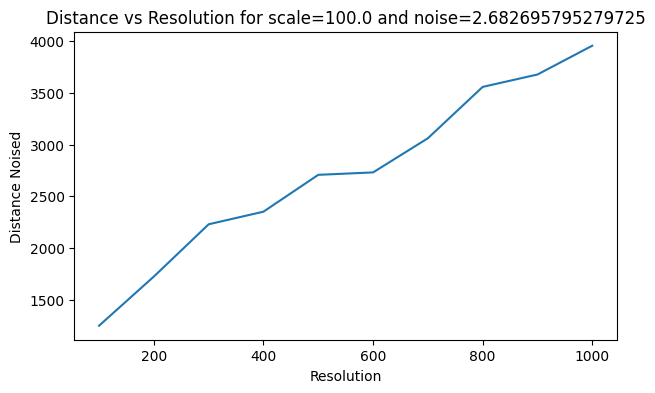

In [168]:
noise_index = 18
scale_index = 0

df2_sub = df2[(df2['Scale_Param'] == unique_scale[scale_index]) & (df2['Noise_Param'] == unique_noises[noise_index])]
plt.figure(figsize=(7,4))
plt.plot(df2_sub['Res'], df2_sub['Distances_Noised'])
plt.xlabel('Resolution')
plt.ylabel('Distance Noised')
plt.title(f'Distance vs Resolution for scale={unique_scale[scale_index]} and noise={unique_noises[noise_index]}')

In [169]:
distances = []
ci_distances = []
start = time.time()

for noise in tqdm(noises):
    
    results = []
    
    for i in range(100):
        noise_p = np.random.normal(0, noise, res)
        p_noised = p + noise_p
        p_noised_pos, p_noised_neg = split_signed_measure(p_noised)
        p_added_neg = p + p_noised_neg

        mean_distribs = (p_added_neg.sum() + p_noised_pos.sum())/2
        p_new = p_added_neg * (mean_distribs / p_added_neg.sum())
        p_noised_new = p_noised_pos * (mean_distribs / p_noised_pos.sum())
        
        result = calc_transport_pot_emd(p_new, p_noised_new, C)[1]
        results.append(result)

    distances.append(np.mean(results))
    mean_dist, ci_dist = confidence_interval(results)
    ci_distances.append(ci_dist)
    
end = time.time()
print(f'elapsed time is {end - start}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:02<00:00,  2.85s/it]

elapsed time is 62.724709272384644


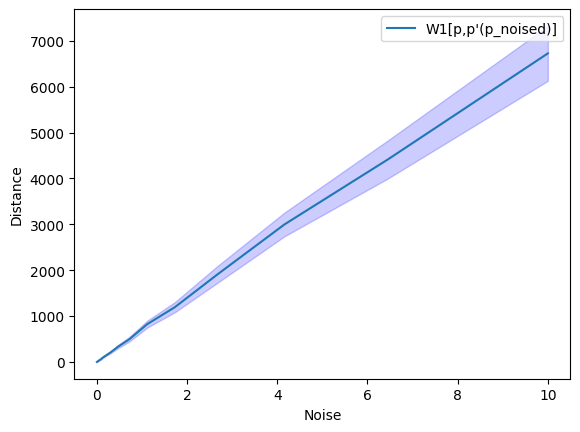

In [170]:
plt.plot(noises, distances, label="W1[p,p'(p_noised)]")
plt.fill_between(noises, 
                 pd.Series(distances) - pd.Series(ci_distances), 
                 pd.Series(distances) + pd.Series(ci_distances), 
                 color='b', alpha=0.2) # light blue shading for confidence interval

plt.xlabel('Noise')
plt.ylabel('Distance')
plt.legend()

In [171]:
partial_df = df2[(df2['Res'] == res) & (df2['Scale_Param'] == scale_param) & (df2['Noise_Param'] < 0.1)]
distances = distances[:len(partial_df.index)]
ci_distances = ci_distances[:len(partial_df.index)]

In [172]:
partial_df.head()

,Res,Noise_Param,Scale_Param,Distances_Classic,Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear,CI_Distances_Classic,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum
880,500.0,0.001000,100.0,29.983148,30.159268,0.995216,0.100594,0.105379,0.954757,0.0,0.204799,149.615909,150.494745,0.200401
890,500.0,0.001551,100.0,29.983148,30.283766,0.991599,0.100594,0.112186,0.896955,0.0,0.248333,149.615909,151.115993,0.200401
900,500.0,0.002404,100.0,29.983148,30.463712,0.988498,0.100594,0.126118,0.798166,0.0,0.418549,149.615909,152.013921,0.200401
910,500.0,0.003728,100.0,29.983148,31.124250,0.972803,0.100594,0.155455,0.647576,0.0,0.639898,149.615909,155.310007,0.200401
920,500.0,0.005780,100.0,29.983148,32.105081,0.955437,0.100594,0.208301,0.483444,0.0,1.006157,149.615909,160.204355,0.200401


In [173]:
x = partial_df['Noise_Param']
y = partial_df['Distances_Noised']

In [174]:
y2 = partial_df['Distances_Classic']

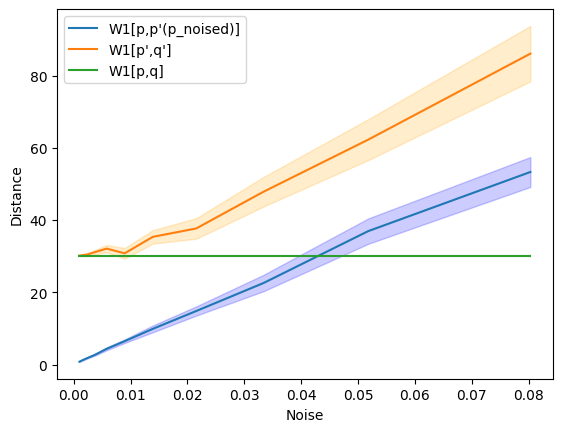

In [175]:
plt.plot(x, distances, label="W1[p,p'(p_noised)]")
plt.fill_between(x, 
                 pd.Series(distances) - pd.Series(ci_distances), 
                 pd.Series(distances) + pd.Series(ci_distances), 
                 color='b', alpha=0.2) # light blue shading for confidence interval
plt.plot(x, y, label="W1[p',q']")
plt.fill_between(x, 
                 y - partial_df['CI_Distances_Noised'], 
                 y + partial_df['CI_Distances_Noised'], 
                 color='orange', alpha=0.2) # light blue shading for confidence interval
plt.plot(x, y2, label="W1[p,q]")
plt.xlabel('Noise')
plt.ylabel('Distance')
# plt.xscale('log')
plt.legend()

In [176]:
noises = df2['Noise_Param'].unique()

In [177]:
df2.head()

,Res,Noise_Param,Scale_Param,Distances_Classic,Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear,CI_Distances_Classic,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum
0,100.0,0.001,100.0,29.985462,30.025662,0.998833,0.225836,0.226376,0.997649,1.486204e-15,0.082488,29.685607,29.725405,1.010101
1,100.0,0.001,200.0,59.970924,60.057413,0.998710,0.225836,0.226225,0.998316,2.972408e-15,0.154203,29.685607,29.728420,2.020202
2,100.0,0.001,300.0,89.956386,89.934135,1.000374,0.225836,0.226302,0.997977,8.917223e-15,0.211926,29.685607,29.678264,3.030303
3,100.0,0.001,400.0,119.941848,120.149646,0.998423,0.225836,0.226567,0.996806,5.944816e-15,0.309980,29.685607,29.737037,4.040404
4,100.0,0.001,500.0,149.927310,150.076194,0.999173,0.225836,0.226217,0.998361,5.944816e-15,0.403476,29.685607,29.715086,5.050505


### Subsetting by scale
Noise is fixed so it doesn't matter if we look strictly at scale or at scale times noise

#### Interactive

In [178]:
def interactive_distance(index):
    noise_param = noises[index]
    df_new_subset = df2[(df2['Res'] == res) & (df2['Noise_Param'] == noise_param)]
    plt.figure(figsize=(10, 6))
    plt.plot(df_new_subset['Scale_Param'], df_new_subset['Distances_Noised'], label=f'Noise = {noise_param:.4f}')
    plt.plot(df_new_subset['Scale_Param'], df_new_subset['Distances_Classic'], label=f'No Noise')
    plt.legend()
    plt.show()

In [179]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(noises) - 1,
    step=1,
    description='Noise Index:',
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=21), Output(…

#### Non-interactive, chosen values of scale

In [37]:
noise_1 = noises[1]
noise_2 = noises[4]
noise_3 = noises[7]

In [38]:
df_new_subset = df2[(df2['Res']==res)& (df2['Noise_Param'] == noise_1)]
df_new_subset2 = df2[(df2['Res']==res)& (df2['Noise_Param'] == noise_2)]
df_new_subset3 = df2[(df2['Res']==res)& (df2['Noise_Param'] == noise_3)]

In [39]:
len(df_new_subset['Distances_Noised'])

10

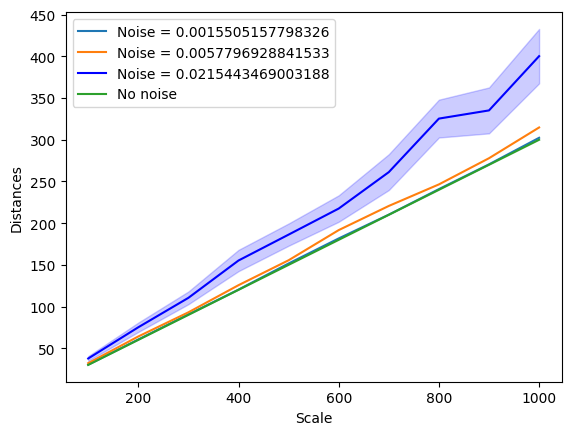

In [40]:
plt.plot(df_new_subset['Scale_Param'], df_new_subset['Distances_Noised'], label=f'Noise = {noise_1}')
plt.plot(df_new_subset2['Scale_Param'], df_new_subset2['Distances_Noised'], label=f'Noise = {noise_2}')
plt.plot(df_new_subset3['Scale_Param'], df_new_subset3['Distances_Noised'], label=f'Noise = {noise_3}', color='b')
plt.fill_between(df_new_subset3['Scale_Param'], 
                 df_new_subset3['Distances_Noised'] - df_new_subset3['CI_Distances_Noised'], 
                 df_new_subset3['Distances_Noised'] + df_new_subset3['CI_Distances_Noised'], 
                 color='b', alpha=0.2) # light blue shading for confidence interval

plt.plot(df_new_subset['Scale_Param'], df_new_subset['Distances_Classic'], label=f'No noise')
plt.xlabel('Scale')
plt.ylabel('Distances')
plt.legend()

In [41]:
ratios3 = df_new_subset3['Distances_Noised'] / df_new_subset3['Distances_Classic']

In [42]:
ratios3

950    1.257014
951    1.252759
952    1.227243
953    1.293458
954    1.241863
955    1.208463
956    1.243893
957    1.355924
958    1.241593
959    1.334327
dtype: float64

### Subsetting by Resolution

#### Interactive:

In [180]:
def interactive_distance(index):
    noise_param = noises[index]
    df_new_subset = df2[(df2['Scale_Param'] == res) & (df2['Noise_Param'] == noise_param)]
    plt.figure(figsize=(10, 6))
    plt.plot(df_new_subset['Res'], df_new_subset['Distances_Noised'], label=f'Noise = {noise_param:.4f}')
    plt.plot(df_new_subset['Res'], df_new_subset['Distances_Classic'], label=f'No Noise')
    plt.legend()
    plt.show()

In [181]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(noises) - 1,
    step=1,
    description='Noise Index:',
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=21), Output(…

#### Non-interactive, chosen values of noise

In [45]:
noise_1 = noises[1]
noise_2 = noises[4]
noise_3 = noises[7]

In [46]:
df_new_subset = df2[(df2['Scale_Param']==res)& (df2['Noise_Param'] == noise_1)]
df_new_subset2 = df2[(df2['Scale_Param']==res)& (df2['Noise_Param'] == noise_2)]
df_new_subset3 = df2[(df2['Scale_Param']==res)& (df2['Noise_Param'] == noise_3)]

In [47]:
len(df_new_subset['Distances_Noised'])

10

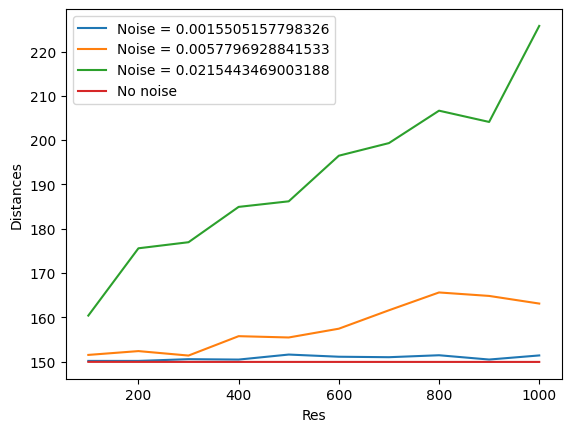

In [48]:
plt.plot(df_new_subset['Res'], df_new_subset['Distances_Noised'], label=f'Noise = {noise_1}')
plt.plot(df_new_subset2['Res'], df_new_subset2['Distances_Noised'], label=f'Noise = {noise_2}')
plt.plot(df_new_subset3['Res'], df_new_subset3['Distances_Noised'], label=f'Noise = {noise_3}')
plt.plot(df_new_subset['Res'], df_new_subset['Distances_Classic'], label=f'No noise')
plt.xlabel('Res')
plt.ylabel('Distances')
plt.legend()

In [49]:
ratios3 = df_new_subset3['Distances_Noised'] / df_new_subset3['Distances_Classic']

In [50]:
print(ratios3)

74      1.069689
294     1.171081
514     1.180257
734     1.233463
954     1.241863
1174    1.310548
1394    1.329556
1614    1.378382
1834    1.361413
2054    1.506029
dtype: float64


## Looking into the slopes as a function of res,scale and the cost matrix

Not sure this is interesting, ask Amit about it.

In [63]:
df2 = pd.read_csv('results_measures_expanded.csv')

In [64]:
new_df_columns = ['Res', 'Scale_Param', 'Slope', 'Intercept', 'Distance']
new_df = pd.DataFrame()

In [65]:
unique_res = df2['Res'].unique()
unique_scale = df2['Scale_Param'].unique()
noises = df2['Noise_Param'].unique()
# noises = noises[:10]
# df2 = df2[df2['Noise_Param'] <= noises[9]]

In [66]:
for i, res_option in enumerate(unique_res):
    for j, scale_option in enumerate(unique_scale):
        
        filtered_df = df2[(df2['Res'] == res_option) & (df2['Scale_Param'] == scale_option)]

        slope, intercept = np.polyfit(noises, filtered_df['Distances_Noised'], 1)
        
        new_row = {
            'Res' : res_option,
            'Scale_Param' : scale_option,
            'Slope' : slope,
            'Intercept' : intercept,
            'Distance': filtered_df['Distances_Noised'].values
        }

        new_df = new_df._append(new_row, ignore_index=True)

In [67]:
new_df.head()

,Res,Scale_Param,Slope,Intercept,Distance
0,100.0,100.0,438.044713,18.283774,"[30.025661604731127, 30.039087240559027, 30.04..."
1,100.0,200.0,890.068131,38.179898,"[60.05741335645521, 60.03679093110363, 60.0946..."
2,100.0,300.0,1364.228304,36.590923,"[89.93413457550679, 90.0287648856502, 89.99356..."
3,100.0,400.0,1751.685837,84.709253,"[120.14964581726808, 120.2884140095972, 120.39..."
4,100.0,500.0,2220.235484,73.480952,"[150.07619358130998, 150.14423012683986, 150.7..."


In [68]:
len(new_df.index)

100

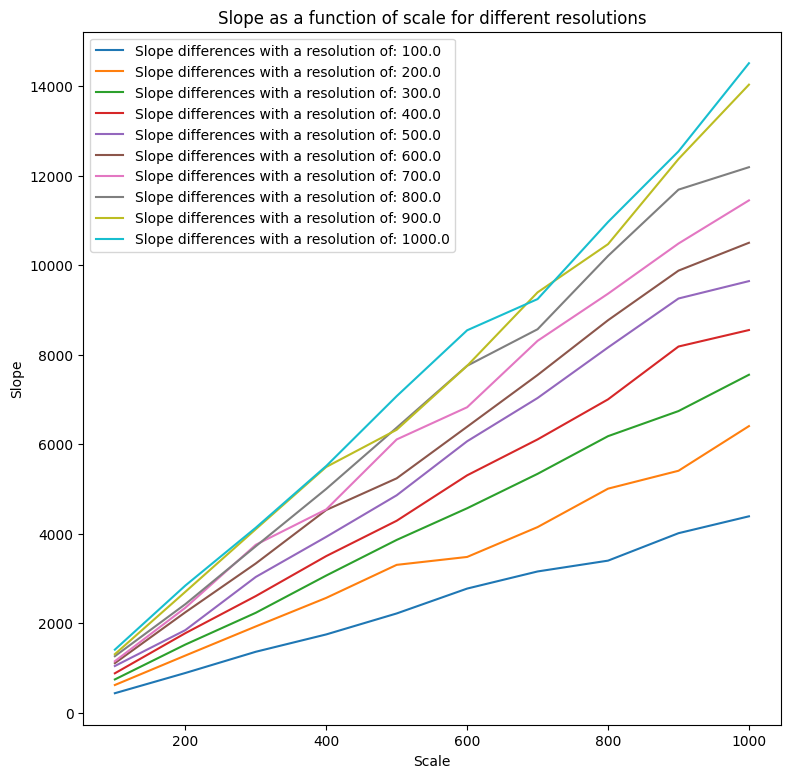

In [69]:
plt.figure(figsize=(9,9))
for res in unique_res:
    curr_df = new_df[new_df['Res'] == res]
    plt.plot(curr_df['Scale_Param'], curr_df['Slope'], label = f'Slope differences with a resolution of: {res}')
plt.xlabel('Scale')
plt.title('Slope as a function of scale for different resolutions')
plt.ylabel('Slope')
plt.legend()

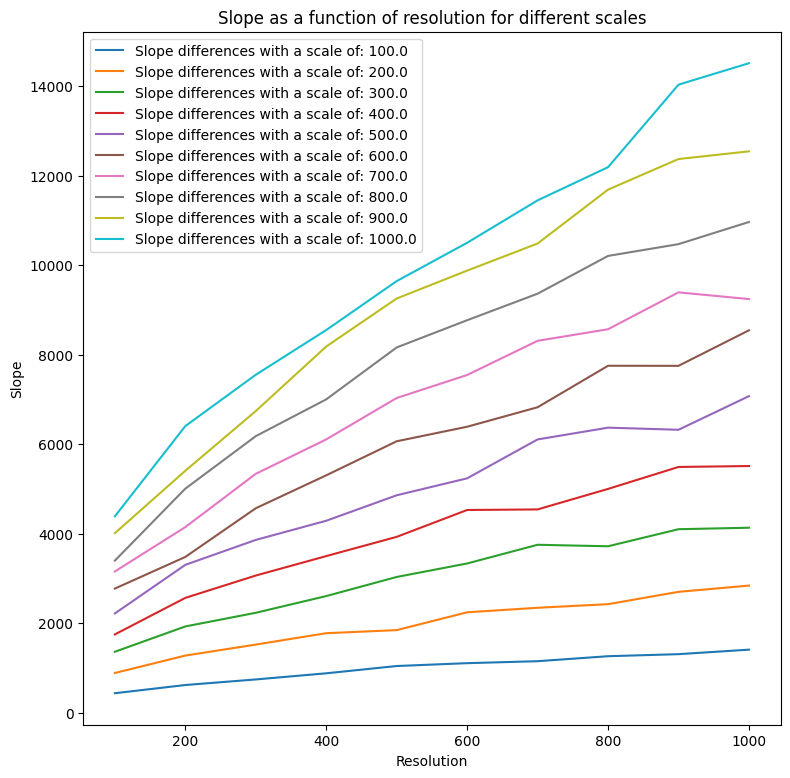

In [70]:
plt.figure(figsize=(9,9))
for scale in unique_scale:
    curr_df = new_df[new_df['Scale_Param'] == scale]
    plt.plot(curr_df['Res'], curr_df['Slope'], label = f'Slope differences with a scale of: {scale}')
plt.xlabel('Resolution')
plt.title('Slope as a function of resolution for different scales')
plt.ylabel('Slope')
plt.legend()

In [71]:
curr_df.head()

,Res,Scale_Param,Slope,Intercept,Distance
9,100.0,1000.0,4390.550058,225.112647,"[300.23884986205866, 299.39320378746334, 302.1..."
19,200.0,1000.0,6405.752049,93.672767,"[301.7420864079417, 301.0754715399757, 300.875..."
29,300.0,1000.0,7552.964648,138.604172,"[301.6470928464077, 299.90131644600666, 303.85..."
39,400.0,1000.0,8552.024066,153.260280,"[299.7104719472049, 303.3871763405745, 302.055..."
49,500.0,1000.0,9645.350452,283.878601,"[300.4941797883296, 302.2269709018012, 305.978..."
